In [35]:
import numpy as np
import matplotlib.pyplot as plt
import os
import xarray as xr
import glob
from xgcm import Grid


#path
BASE = '/scratch/ab10313/pleiades/'

PATH_NN = BASE+'NN_data_smooth/'
#os.mkdir(PATH_NN)

PATH_LIST_full = glob.glob(BASE+'*_smooth/preprcossed_data/')
# remove two regions without strong w'b'
PATH_LIST_full.remove(BASE+'04_equator_atlantic_smooth/preprcossed_data/')
PATH_LIST_full.remove(BASE+'10_north_pacific_smooth/preprcossed_data/')
PATH_LIST_full.remove(BASE+'15_bengal_smooth/preprcossed_data/') 

In [36]:
PATH_LIST_full

['/scratch/ab10313/pleiades/12_agulhas_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/11_new_zealand_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/01_gulf_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/03_south_atlantic_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/05_argentina_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/13_australia_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/14_indian_ocean_smooth/preprcossed_data/']

In [23]:
# function that splits datasets along the spacial axes and concats them back into single array under time

def normalize(data):
    normalized_data =  (data - np.nanmean(data))/np.nanstd(data)
    data_mean = np.tile(np.nanmean(data),(845))
    data_std = np.tile(np.nanstd(data),(845))
    return normalized_data,data_mean, data_std

def smooth(data,time_window, coarsen_factor):
    if len(data.dims) == 3:
        smoothed_data = data.rolling(time=time_window, center=True).mean().dropna(dim="time", how="all").coarsen(i=coarsen_factor,j=coarsen_factor, boundary="trim").mean()
    elif len(data.dims) == 2:
        smoothed_data = np.tile(data.coarsen(i=coarsen_factor,j=coarsen_factor, boundary="trim").mean(),(845,1,1))
    return smoothed_data


def load_data_norm(var_name_string,time_window=15,coarsen_factor=12):
    PATH_LIST = glob.glob(BASE+'*_smooth/preprcossed_data/'+var_name_string+'.nc') 
    data_0 = xr.open_dataarray(PATH_LIST[0])
    data_smooth_0 = smooth(data_0,time_window,coarsen_factor)
    data_smooth_norm_0, data_mean_0, data_std_0 = normalize(data_smooth_0)
    data_app = data_smooth_norm_0
    data_mean_app = data_mean_0
    data_std_app = data_std_0
    for i_file in np.arange(1,len(PATH_LIST)):
        PATH = PATH_LIST[i_file]
        data = xr.open_dataarray(PATH)
        data_smooth = smooth(data,time_window,coarsen_factor)
        data_smooth_norm, data_mean, data_std = normalize(data_smooth)
        data_app = np.concatenate((data_app,data_smooth_norm),axis=0)
        data_mean_app = np.concatenate((data_mean_app,data_mean),axis=0)
        data_std_app = np.concatenate((data_std_app,data_std),axis=0)
    return data_app, data_mean_app, data_std_app


def load_data(var_name_string,time_window=15,coarsen_factor=12):
    PATH_LIST = glob.glob(BASE+'*_smooth/preprcossed_data/'+var_name_string+'.nc') 
    data_0 = xr.open_dataarray(PATH_LIST[0])
    data_smooth_0 = smooth(data_0,time_window,coarsen_factor)
    data_app = data_smooth_0
    for i_file in np.arange(1,len(PATH_LIST)):
        PATH = PATH_LIST[i_file]
        data = xr.open_dataarray(PATH)
        data_smooth = smooth(data,time_window,coarsen_factor)
        data_app = np.concatenate((data_app,data_smooth),axis=0)
    return data_app

def FK_param(PATH,time_window=15,coarsen_factor=12):
    # FK08 parameterization inputs
    tau = 86400
    FCOR = smooth(xr.open_dataarray(PATH+'FCOR.nc'),time_window,coarsen_factor)
    
    # coarse-res horizontal buoyancy gradient
    B = smooth(xr.open_dataarray(PATH+'B.nc'),time_window=15,coarsen_factor=12)
    B_x = (B.diff(dim='i')/(12*B.dxF)).interp(i=B.i,j=B.j,kwargs={"fill_value": "extrapolate"}).values
    B_y = (B.diff(dim='j')/(12*B.dyF)).interp(i=B.i,j=B.j,kwargs={"fill_value": "extrapolate"}).values
    grad_B = np.sqrt(B_y**2 + B_x**2)
    
    HML = smooth(xr.open_dataarray(PATH+'HML.nc'),time_window,coarsen_factor).values
    
    WB_FK = ((HML**2) * (grad_B**2))/np.sqrt(FCOR**2 + tau**-2)#( (grad_B**2))/np.sqrt(FCOR**2 + tau**-2)#
    
    return WB_FK
    
    
def load_data_FK(time_window=15,coarsen_factor=12):
    PATH_LIST_full = glob.glob(BASE+'*_smooth/preprcossed_data/') 
    WB_FK_0 = FK_param(PATH_LIST_full[0])
    data_app = WB_FK_0
    for i_file in np.arange(1,len(PATH_LIST_full)):
        WB_FK = FK_param(PATH_LIST_full[i_file])
        data_app = np.concatenate((data_app,WB_FK),axis=0)
    return data_app

    
    
def WB_sg_target(PATH,time_window=15,coarsen_factor=12):
    # WB
    B = smooth(xr.open_dataarray(PATH+'B.nc'),time_window,coarsen_factor).values
    W = smooth(xr.open_dataarray(PATH+'W.nc'),time_window,coarsen_factor).values
    WB = smooth(xr.open_dataarray(PATH+'WB.nc'),time_window,coarsen_factor).values
    
    # WB subgrid
    WB_sg = WB - W*B
    WB_sg_norm, WB_sg_mean, WB_sg_std = normalize(WB_sg)
    return WB_sg_norm, WB_sg_mean, WB_sg_std


    
def load_data_WB(time_window=15,coarsen_factor=12):
    PATH_LIST_full = glob.glob(BASE+'*_smooth/preprcossed_data/') 
    WB_sg_norm_0, WB_sg_mean_0, WB_sg_std_0 = WB_sg_target(PATH_LIST_full[0])
    data_app = WB_sg_norm_0
    data_mean_app = WB_sg_mean_0
    data_std_app = WB_sg_std_0
    for i_file in np.arange(1,len(PATH_LIST_full)):
        WB_sg_norm, WB_sg_mean, WB_sg_std = WB_sg_target(PATH_LIST_full[i_file])
        data_app = np.concatenate((data_app,WB_sg_norm),axis=0)
        data_mean_app = np.concatenate((data_mean_app,WB_sg_mean),axis=0)
        data_std_app = np.concatenate((data_std_app,WB_sg_std),axis=0)
    return data_app, data_mean_app, data_std_app

In [47]:
def load_gradients(time_window=15,coarsen_factor=12):
    PATH_LIST_full = glob.glob(BASE+'*_smooth/preprcossed_data/') 
    # coarse-res gradients
    B = smooth(xr.open_dataarray(PATH_LIST_full[0]+'B.nc'),time_window=15,coarsen_factor=12)
    B_x = (B.diff(dim='i')/(12*B.dxF)).interp(i=B.i,j=B.j,kwargs={"fill_value": "extrapolate"}).values
    B_y = (B.diff(dim='j')/(12*B.dyF)).interp(i=B.i,j=B.j,kwargs={"fill_value": "extrapolate"}).values
    
    U = smooth(xr.open_dataarray(PATH_LIST_full[0]+'U.nc'),time_window=15,coarsen_factor=12)
    U_x = (U.diff(dim='i')/(12*U.dxF)).interp(i=U.i,j=U.j,kwargs={"fill_value": "extrapolate"}).values
    U_y = (U.diff(dim='j')/(12*U.dyF)).interp(i=U.i,j=U.j,kwargs={"fill_value": "extrapolate"}).values
    
    V = smooth(xr.open_dataarray(PATH_LIST_full[0]+'V.nc'),time_window=15,coarsen_factor=12)
    V_x = (V.diff(dim='i')/(12*V.dxF)).interp(i=V.i,j=V.j,kwargs={"fill_value": "extrapolate"}).values
    V_y = (V.diff(dim='j')/(12*V.dyF)).interp(i=V.i,j=V.j,kwargs={"fill_value": "extrapolate"}).values
    
    # grad B
    grad_B_0 ,_,_= normalize(np.sqrt(B_y**2 + B_x**2))
    grad_B_app = grad_B_0
    
    # divergence
    div_0,_,_ = normalize(U_x + V_y)
    div_app = div_0
    
    # vorticity
    vort_0,_,_ = normalize(V_x - U_y)
    vort_app = vort_0
    
    # strain
    strain_0,_,_ = normalize(np.sqrt((U_x - V_y)**2 + (V_x + U_y)**2))
    strain_app = strain_0

    for i_file in np.arange(1,len(PATH_LIST_full)):
        # coarse-res gradients
        B = smooth(xr.open_dataarray(PATH_LIST_full[i_file]+'B.nc'),time_window=15,coarsen_factor=12)
        B_x = (B.diff(dim='i')/(12*B.dxF)).interp(i=B.i,j=B.j,kwargs={"fill_value": "extrapolate"}).values
        B_y = (B.diff(dim='j')/(12*B.dyF)).interp(i=B.i,j=B.j,kwargs={"fill_value": "extrapolate"}).values

        U = smooth(xr.open_dataarray(PATH_LIST_full[i_file]+'U.nc'),time_window=15,coarsen_factor=12)
        U_x = (U.diff(dim='i')/(12*U.dxF)).interp(i=U.i,j=U.j,kwargs={"fill_value": "extrapolate"}).values
        U_y = (U.diff(dim='j')/(12*U.dyF)).interp(i=U.i,j=U.j,kwargs={"fill_value": "extrapolate"}).values

        V = smooth(xr.open_dataarray(PATH_LIST_full[i_file]+'V.nc'),time_window=15,coarsen_factor=12)
        V_x = (V.diff(dim='i')/(12*V.dxF)).interp(i=V.i,j=V.j,kwargs={"fill_value": "extrapolate"}).values
        V_y = (V.diff(dim='j')/(12*V.dyF)).interp(i=V.i,j=V.j,kwargs={"fill_value": "extrapolate"}).values

        # grad B
        grad_B ,_,_= normalize(np.sqrt(B_y**2 + B_x**2))
        grad_B_app = np.concatenate((grad_B_app,grad_B),axis=0)

        # divergence
        div,_,_ = normalize(U_x + V_y)
        div_app = np.concatenate((div_app,div),axis=0)

        # vorticity
        vort,_,_ = normalize(V_x - U_y)
        vort_app = np.concatenate((vort_app,vort),axis=0)

        # strain
        strain,_,_ = normalize(np.sqrt((U_x - V_y)**2 + (V_x + U_y)**2))
        strain_app = np.concatenate((strain_app,strain),axis=0)
    
                             
    return grad_B_app, div_app, vort_app, strain_app

In [24]:
def FK_param_Lf(PATH,time_window=15,coarsen_factor=12):
    # FK08 parameterization inputs
    tau = 86400
    FCOR = smooth(xr.open_dataarray(PATH+'FCOR.nc'),time_window,coarsen_factor)
    
    HML = smooth(xr.open_dataarray(PATH+'HML.nc'),time_window,coarsen_factor).values
    #also making Nsquared very small but not zero to avoid singularity
    Nsquared = smooth(xr.open_dataarray(PATH+'Nsquared.nc'),time_window,coarsen_factor).values
    Nsquared[Nsquared<=0]=1e-25
    
    # WB FK11 with Lf rescaling factor
    ds = 25e3 # approx 1/4 degree resolution  ~ 25km
    Lf = (np.sqrt(Nsquared)*(-HML))/np.sqrt(FCOR**2 + tau**-2)
    return Lf 
    
    
def load_data_FK_Lf(time_window=15,coarsen_factor=12):
    PATH_LIST_full = glob.glob(BASE+'*_smooth/preprcossed_data/') 
    WB_FK_0 = FK_param_Lf(PATH_LIST_full[0])
    data_app = WB_FK_0
    for i_file in np.arange(1,len(PATH_LIST_full)):
        WB_FK = FK_param_Lf(PATH_LIST_full[i_file])
        data_app = np.concatenate((data_app,WB_FK),axis=0)
    return data_app



def Bod_param_Lf(PATH,time_window=15,coarsen_factor=12):
    # Bodner23 parameterization inputs
    FCOR = smooth(xr.open_dataarray(PATH+'FCOR.nc'),time_window,coarsen_factor)

    TAUX = smooth(xr.open_dataarray(PATH+'TAUX.nc'),time_window,coarsen_factor).values
    TAUY = smooth(xr.open_dataarray(PATH+'TAUY.nc'),time_window,coarsen_factor).values
    TAU = np.sqrt(TAUY**2 + TAUX**2)

    Q = smooth(xr.open_dataarray(PATH+'Q.nc'),time_window,coarsen_factor).values
    HBL = smooth(xr.open_dataarray(PATH+'HBL.nc'),time_window,coarsen_factor).values
    
    # WB FK11 with Bod Lf rescaling factor
    ds = 25e3 # approx 1/4 degree resolution  ~ 25km
    m_star = 0.5
    n_star = 0.066
    Cl = 0.25
    rho0 = 1025
    u_star = np.sqrt(np.abs(TAU)/rho0)
    
    # w_star
    cp_w = 4.2e3 
    grav = 9.81 
    gcp = grav/cp_w 
    t00b = 5000 
    bfac = 1 
    batag = bfac*grav/t00b  #multiply temp*batag to get buoyancy
    galpha = 1.962e-3              #conversion from T to b (Ttob)
    w_fac = galpha/rho0/cp_w 
    w_star = (abs(batag*gcp * Q*HBL))**(1/3) 

    Lf = (Cl * (m_star*u_star**3 + n_star*w_star**3)**(2/3))/((FCOR**2)*(HBL))
    return Lf
    
    
def load_data_Bod_Lf(time_window=15,coarsen_factor=12):
    PATH_LIST_full = glob.glob(BASE+'*_smooth/preprcossed_data/') 
    WB_Bod_0 = Bod_param_Lf(PATH_LIST_full[0])
    data_app = WB_Bod_0
    for i_file in np.arange(1,len(PATH_LIST_full)):
        WB_Bod = Bod_param_Lf(PATH_LIST_full[i_file])
        data_app = np.concatenate((data_app,WB_Bod),axis=0)
    return data_app

In [25]:
WB_FK = load_data_FK()
np.save(PATH_NN+'WB_FK.npy',WB_FK)

In [8]:
WB_sg = np.load(PATH_NN+'WB_sg.npy')
WB_sg_mean = np.load(PATH_NN+'WB_sg_mean.npy')
WB_sg_std = np.load(PATH_NN+'WB_sg_std.npy')

(0.0, 40.0, 0.0, 40.0)

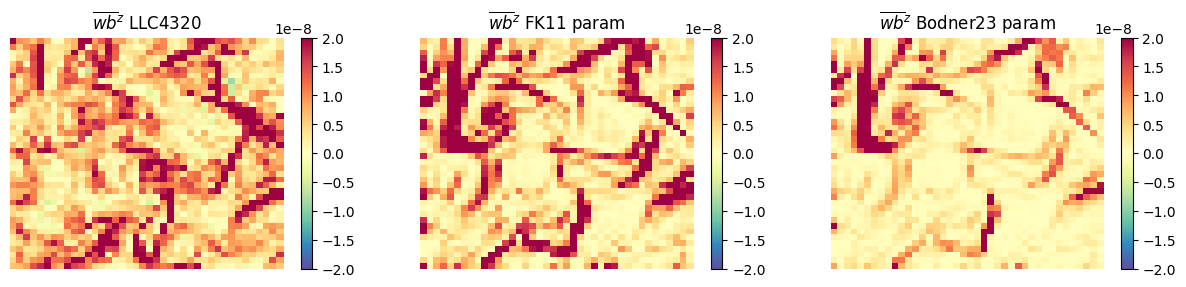

In [31]:
plt.subplots(nrows=1, ncols=3, figsize=(15, 3))

it =5001
mean_it = WB_sg_mean[it]
std_it = WB_sg_std[it]

plt.pcolor(WB_sg[it]*mean_it + std_it)
plt.colorbar()

plt.subplot(131)
plt.pcolor(WB_sg[it]*std_it + mean_it,cmap='Spectral_r', vmin=-2e-8, vmax=2e-8)
plt.title('$\overline{wb}^z$ LLC4320',fontsize = 12)
plt.colorbar()
plt.axis('off')

plt.subplot(132)
plt.pcolor((0.07*25e3/np.maximum(Lf_FK11[it],5000))*WB_FK[it],cmap='Spectral_r', vmin=-2e-8, vmax=2e-8)
plt.title('$\overline{wb}^z$ FK11 param',fontsize = 12)
plt.colorbar()
plt.axis('off')

plt.subplot(133)
plt.pcolor((0.07*25e3/(Lf_BD23[it]))*WB_FK[it],cmap='Spectral_r', vmin=-2e-8, vmax=2e-8)
plt.title('$\overline{wb}^z$ Bodner23 param',fontsize = 12)
plt.colorbar()
plt.axis('off')

In [13]:
# WB subgrid
WB_sg, WB_sg_mean, WB_sg_std = load_data_WB()

np.save(PATH_NN+'WB_sg.npy',WB_sg)
np.save(PATH_NN+'WB_sg_mean.npy',WB_sg_mean)
np.save(PATH_NN+'WB_sg_std.npy',WB_sg_std)

In [28]:
# Lf from FK and Bod
Lf_FK11 = load_data_FK_Lf()
Lf_BD23 = load_data_Bod_Lf()
#WB_FK = load_data_FK()

np.save(PATH_NN+'Lf_FK11.npy',Lf_FK11)
np.save(PATH_NN+'Lf_BD23.npy',Lf_BD23)
#np.save(PATH_NN+'WB_FK.npy',WB_FK)

In [5]:
# WB FK parameterization
WB_FK = load_data_FK()
WB_FK_Lf = load_data_FK_Lf()
WB_BD_Lf = load_data_Bod_Lf()

np.save(PATH_NN+'WB_FK_Lf.npy',WB_FK_Lf)
np.save(PATH_NN+'WB_BD_Lf.npy',WB_BD_Lf)
np.save(PATH_NN+'WB_FK.npy',WB_FK)

In [34]:
TAUX = smooth(xr.open_dataarray(PATH_LIST_full[0]+'TAUX.nc'),time_window=15,coarsen_factor=12).values
TAUY = smooth(xr.open_dataarray(PATH_LIST_full[0]+'TAUY.nc'),time_window=15,coarsen_factor=12).values
TAU = np.sqrt(TAUY**2 + TAUX**2)

In [48]:
grad_B, div, vort, strain = load_gradients()

In [49]:
np.save(PATH_NN+'grad_B.npy',grad_B)
np.save(PATH_NN+'div.npy',div)
np.save(PATH_NN+'vort.npy',vort)
np.save(PATH_NN+'strain.npy',strain)

In [65]:
np.isnan(Lf_FK11).any()

False

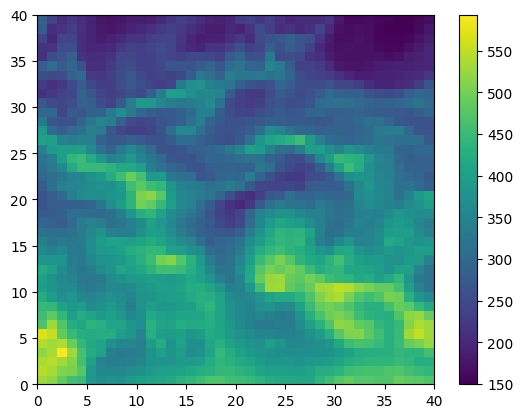

In [62]:
plt.pcolor(-Lf_BD23[3000])
plt.colorbar()

In [15]:
# load FK08 variables relevant for w'b' parameterization:
FCOR, FCOR_mean, FCOR_std = load_data_norm('FCOR') 
B_x, B_x_mean, B_x_std = load_data_norm('B_x') 
B_y, B_y_mean, B_y_std = load_data_norm('B_y')
grad_B = np.sqrt(B_y**2 + B_x**2)

HML, HML_mean, HML_std = load_data_norm('HML') 
Nsquared, Nsquared_mean, Nsquared_std = load_data_norm('Nsquared')


In [50]:
Nsquared, Nsquared_mean, Nsquared_std = load_data_norm('Nsquared')


In [54]:
np.save(PATH_NN+'Nsquared.npy',Nsquared)


In [16]:
# load other variables that may be relevant for w'b':

U, U_mean, U_std = load_data_norm('U') 
V, V_mean, V_std = load_data_norm('V') 

TAUX, TAUX_mean, TAUX_std = load_data_norm('TAUX')
TAUY, TAUY_mean, TAUY_std = load_data_norm('TAUY')
TAU = np.sqrt(TAUY**2 + TAUX**2)

Q, Q_mean, Q_std = load_data_norm('Q')
HBL, HBL_mean, HBL_std = load_data_norm('HBL')


In [18]:
# save normalized NN data

np.save(PATH_NN+'grad_B.npy',grad_B)
np.save(PATH_NN+'FCOR.npy',FCOR)
#np.save(PATH_NN+'WB_sg.npy',WB_sg)
#np.save(PATH_NN+'WB_FK.npy',WB_FK)
np.save(PATH_NN+'HML.npy',HML)

np.save(PATH_NN+'TAU.npy',TAU)
np.save(PATH_NN+'U.npy',U)
np.save(PATH_NN+'V.npy',V)
np.save(PATH_NN+'Q.npy',Q)
np.save(PATH_NN+'HBL.npy',HBL)
np.save(PATH_NN+'FCOR.npy',FCOR)
np.save(PATH_NN+'Nsquared.npy',Nsquared)
#np.save(PATH_NN+'WB_sg.npy',WB_sg)